# Who Gets Paid Above League Average

This project uses two datasets from https://www.basketball-reference.com/. The goal of this project is to analyze the player stats from the 2020-2021 season where the last stats provided were added on April 6th, 2021. The other dataset contains the salaries for each player. For the purposes of this project, the 2020-2021 and possibly the 2021-2022 salaries are relevant. Analyzing the statistics, I want to train a machine learning model to be able to predict which players earned above league average. I'm interested in which stats predict higher salaries, which players, the model deems to not have earned their contracts and who has outplayed their contract at least relative to the league average (the players had already negotiated their contracts and money prior to putting up these stats) and if the analysis of this data could be used to compare a season perhaps in the 1980s to see what are the best stats to have to essentially increase your earning power above the league average.

In [329]:
import sys
import os
os.chdir('C:\\Users\\wally')
import numpy as np
from scipy.io import arff
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
import matplotlib.patches as mpatches
import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, classification_report, roc_curve, plot_roc_curve, auc, precision_recall_curve, plot_precision_recall_curve, average_precision_score, log_loss,plot_confusion_matrix
from sklearn.model_selection import cross_val_score
plt.rcParams.update(plt.rcParamsDefault)
os.chdir('C:\\Users\\wally\\OneDrive\\Documents\\Python Scripts')

In [330]:
stats = pd.read_csv('C:\\Users\\wally\\OneDrive\\Documents\\Python Scripts\\basketball\\Player Stats 2020-21')
salaries = pd.read_csv('C:\\Users\\wally\\OneDrive\\Documents\\Python Scripts\\basketball\\Salaries 2020-21')

In [331]:
salaries = salaries.rename(columns = {'Unnamed: 0': 'salary_rank', 'Salary': 'salary_20-21', 'Salary.1': 'salary_21-22', 'Unnamed: 1': 'player_name','Unnamed: 2':'team','Unnamed: 9': 'signed_using','Unnamed: 10': 'guaranteed_money'})
salaries = salaries.drop(['Salary.2','Salary.3','Salary.4','Salary.5'], axis = 1)

Seeing as there were so many NaN values for salaries beyond the 2021-22 season, I thought it was useful to drop any columns beyond those two salary years.

In [332]:
dup_salaries = salaries[salaries['player_name'].duplicated(keep = False)]
display(dup_salaries)

,salary_rank,player_name,team,salary_20-21,salary_21-22,signed_using,guaranteed_money
18,18,Blake Griffin\griffbl01,DET,$33685241,$29764126,NaN,$62219691
32,32,Andre Drummond\drumman01,CLE,$29546311,NaN,NaN,$28751775
59,59,LaMarcus Aldridge\aldrila01,SAS,$19078340,NaN,NaN,$18200000
70,70,Gorgui Dieng\dienggo01,MEM,$17587688,NaN,NaN,$16587688
137,137,Nicolas Batum\batumni01,CHO,$11608231,$9043478,NaN,$27130434
218,218,Elfrid Payton\paytoel01,NYK,$5760000,NaN,Cap Space,$5760000
276,276,Patrick Patterson\pattepa01,LAC,$3814768,$737066,Non Bird,$3077701
300,300,Jeff Teague\teaguje01,ORL,$3372826,NaN,NaN,$2564753
303,303,Nicolas Batum\batumni01,LAC,$11608231,$9043478,Minimum Salary,$2564753
304,304,Wayne Ellington\ellinwa01,DET,$3005225,NaN,Minimum Salary,$2564753


I removed all the rows where players were bought out and thus entered twice; once for the team they were prior to being bought out and once for the team they were signed to and signed for close to a minimum. I kept the team where they compiled most of their stats. I also removed two players who had no information for salaries. So far the columns 'salary_21-22', 'signed_using' and 'guaranteed_money' still have NaN values but I believe thats fine considering that I probably won't use these columns for analysis. Subject to change.

In [333]:
salaries = salaries.drop([445, 451, 470, 469, 276, 137, 300, 304, 322, 452, 467, 448, 0, 489, 496])

After a while of research, I found a way to remove the player tag after the actual player name! It was a bit tricky because the backslash is a special character and the way to escape it, involves a backslash! Finally got it!

In [334]:
salaries['player_name'] = (salaries['player_name'].str.split(r'\\').str[0])
salaries.head(3)                                                            

,salary_rank,player_name,team,salary_20-21,salary_21-22,signed_using,guaranteed_money
1,1,Stephen Curry,GSW,$43006362,$45780966,Bird Rights,$88787328
2,2,Russell Westbrook,WAS,$41358814,$44211146,Bird Rights,$85569960
3,3,Chris Paul,PHO,$41358814,$44211146,Bird Rights,$41358814


Now I'm going to remove the dollar signs from the colums.

In [335]:
salaries['salary_20-21'] = salaries['salary_20-21'].str.replace('$','')
salaries['salary_21-22'] = salaries['salary_21-22'].str.replace('$','')
salaries['guaranteed_money'] = salaries['guaranteed_money'].str.replace('$','')
salaries.head(10)                                                            

,salary_rank,player_name,team,salary_20-21,salary_21-22,signed_using,guaranteed_money
1,1,Stephen Curry,GSW,43006362,45780966,Bird Rights,88787328
2,2,Russell Westbrook,WAS,41358814,44211146,Bird Rights,85569960
3,3,Chris Paul,PHO,41358814,44211146,Bird Rights,41358814
4,4,John Wall,HOU,41254920,44310840,Bird Rights,85565760
5,5,James Harden,BRK,40824000,43848000,Bird Rights,84672000
6,6,LeBron James,LAL,39219565,41180544,Cap Space,124875097
7,7,Kevin Durant,BRK,39058950,40918900,Sign and Trade,79977850
8,8,Paul George,LAC,35450412,39344970,Maximum Salary,162928115
9,9,Klay Thompson,GSW,35361360,37980720,Bird Rights,157161600
10,10,Mike Conley,UTA,34504132,NaN,Cap Space,34504132


In [336]:
salaries['salary_21-22'] = salaries['salary_21-22'].fillna(0)
salaries_na = salaries[salaries['salary_20-21'].isnull()]
display(salaries_na)

,salary_rank,player_name,team,salary_20-21,salary_21-22,signed_using,guaranteed_money


In [337]:
stats['Player'] = (stats['Player'].str.split(r'\\').str[0])
stats.head(3)

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1,Precious Achiuwa,PF,21,MIA,47,2,593,101,178,0.567,0,0,NaN,101,178,0.567,0.567,47,94,0.500,58,111,169,25,15,24,38,72,249
1,2,Jaylen Adams,PG,24,MIL,7,0,18,1,8,0.125,0,2,0.0,1,6,0.167,0.125,0,0,NaN,0,3,3,2,0,0,0,1,2
2,3,Steven Adams,C,27,NOP,45,45,1268,156,250,0.624,0,3,0.0,156,247,0.632,0.624,47,105,0.448,176,227,403,89,41,30,67,93,359


In [338]:
stats_3P_na = stats[stats['3P%'].isnull()]
display(stats_3P_na)

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1,Precious Achiuwa,PF,21,MIA,47,2,593,101,178,0.567,0,0,NaN,101,178,0.567,0.567,47,94,0.500,58,111,169,25,15,24,38,72,249
11,9,Jarrett Allen,C,22,BRK,12,5,320,44,65,0.677,0,0,NaN,44,65,0.677,0.677,46,61,0.754,38,87,125,20,7,19,22,21,134
18,13,Kostas Antetokounmpo,PF,23,LAL,9,0,35,2,5,0.400,0,0,NaN,2,5,0.400,0.400,2,6,0.333,2,10,12,0,2,3,8,3,6
30,23,Udoka Azubuike,C,21,UTA,12,0,49,4,7,0.571,0,0,NaN,4,7,0.571,0.571,4,6,0.667,4,9,13,0,1,4,3,8,12
64,55,Marques Bolden,C,22,CLE,6,0,29,1,3,0.333,0,0,NaN,1,3,0.333,0.333,5,8,0.625,3,3,6,0,2,2,2,0,7
69,60,Brian Bowen,SF,22,IND,3,0,8,1,2,0.500,0,0,NaN,1,2,0.500,0.500,1,1,1.000,0,1,1,0,0,0,0,1,3
78,64,Ignas Brazdeikis,SF,22,NYK,4,0,7,0,1,0.000,0,0,NaN,0,1,0.000,0.000,2,2,1.000,1,1,2,1,0,0,1,0,2
86,71,Moses Brown,C,21,OKC,21,10,413,67,117,0.573,0,0,NaN,67,117,0.573,0.573,47,78,0.603,65,108,173,4,11,24,16,40,181
98,81,Devontae Cacok,PF,24,LAL,12,1,54,10,17,0.588,0,0,NaN,10,17,0.588,0.588,3,7,0.429,8,10,18,1,5,2,3,5,23
102,85,Clint Capela,C,26,ATL,44,44,1310,288,488,0.590,0,0,NaN,288,488,0.590,0.590,89,151,0.589,211,414,625,35,33,100,55,103,665


There were rows in our stats dataset for players that played on two teams. There was one entry for total games, one for their first team and one for their second team. Below, I confirm there are no multiple entries.

In [339]:
stats = stats.drop_duplicates(subset = 'Player', keep = 'first')
count_stats = stats['Player'].value_counts()
print(count_stats.head(5))

Joe Ingles            1
D.J. Wilson           1
Kristaps Porziņģis    1
Kemba Walker          1
Thomas Bryant         1
Name: Player, dtype: int64


In [340]:
print(stats['2P%'].mean())
print(stats['3P%'].mean())
print(stats['FT%'].mean())

0.5024249011857715
0.31116155419222935
0.7466597938144333


In [341]:
two_p_per = stats['2P%'].mean()
three_p_per = stats['3P%'].mean()
ft_p_per = stats['FT%'].mean()

In [342]:
stats_2P_na = stats[stats['2P%'].isnull()]
display(stats_2P_na)

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
136,111,Nate Darling,SG,22,CHO,4,0,16,2,6,0.333,2,6,0.333,0,0,NaN,0.500,0,0,NaN,1,0,1,1,0,0,0,0,6
225,182,Ashton Hagans,PG,21,MIN,2,0,4,0,0,NaN,0,0,NaN,0,0,NaN,NaN,0,0,NaN,0,0,0,0,0,0,1,0,0
346,275,Meyers Leonard,C,28,MIA,3,2,29,3,7,0.429,3,7,0.429,0,0,NaN,0.643,1,2,0.5,0,7,7,2,0,0,2,5,10
360,287,Will Magnay,C,22,NOP,1,0,3,0,1,0.000,0,1,0.000,0,0,NaN,0.000,0,0,NaN,0,0,0,0,0,0,1,1,0
454,370,Anžejs Pasečņiks,C,25,WAS,1,0,6,0,1,0.000,0,1,0.000,0,0,NaN,0.000,0,0,NaN,1,0,1,1,0,0,5,2,0


In [343]:
stats['2P%'] = stats['2P%'].fillna(two_p_per)
stats['3P%'] = stats['3P%'].fillna(three_p_per)
stats['FT%'] = stats['FT%'].fillna(ft_p_per)

In [344]:
stats_FG_na = stats[stats['FG%'].isnull()]
display(stats_FG_na)

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
225,182,Ashton Hagans,PG,21,MIN,2,0,4,0,0,NaN,0,0,0.311162,0,0,0.502425,NaN,0,0,0.74666,0,0,0,0,0,0,1,0,0


In [345]:
stats = stats.drop([225])

In [346]:
stats = stats.rename(columns = {'Player': 'player_name'})

In [347]:
stats_salaries = stats.merge(salaries[['salary_rank','player_name', 'salary_20-21', 'salary_21-22', 'signed_using', 'guaranteed_money']])

After merging the two datasets, there are 439 players left. The rows that were removed had no stats for the season (i.e. Klay Thompson, Jaren Jackson Jr., etc.).

In [348]:
stats_salaries.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 439 entries, 0 to 438
Data columns (total 35 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Rk                439 non-null    int64  
 1   player_name       439 non-null    object 
 2   Pos               439 non-null    object 
 3   Age               439 non-null    int64  
 4   Tm                439 non-null    object 
 5   G                 439 non-null    int64  
 6   GS                439 non-null    int64  
 7   MP                439 non-null    int64  
 8   FG                439 non-null    int64  
 9   FGA               439 non-null    int64  
 10  FG%               439 non-null    float64
 11  3P                439 non-null    int64  
 12  3PA               439 non-null    int64  
 13  3P%               439 non-null    float64
 14  2P                439 non-null    int64  
 15  2PA               439 non-null    int64  
 16  2P%               439 non-null    float64
 1

In [349]:
stats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 510 entries, 0 to 636
Data columns (total 30 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Rk           510 non-null    int64  
 1   player_name  510 non-null    object 
 2   Pos          510 non-null    object 
 3   Age          510 non-null    int64  
 4   Tm           510 non-null    object 
 5   G            510 non-null    int64  
 6   GS           510 non-null    int64  
 7   MP           510 non-null    int64  
 8   FG           510 non-null    int64  
 9   FGA          510 non-null    int64  
 10  FG%          510 non-null    float64
 11  3P           510 non-null    int64  
 12  3PA          510 non-null    int64  
 13  3P%          510 non-null    float64
 14  2P           510 non-null    int64  
 15  2PA          510 non-null    int64  
 16  2P%          510 non-null    float64
 17  eFG%         510 non-null    float64
 18  FT           510 non-null    int64  
 19  FTA     

In [350]:
salaries.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 482 entries, 1 to 495
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   salary_rank       482 non-null    object
 1   player_name       482 non-null    object
 2   team              482 non-null    object
 3   salary_20-21      482 non-null    object
 4   salary_21-22      482 non-null    object
 5   signed_using      389 non-null    object
 6   guaranteed_money  459 non-null    object
dtypes: object(7)
memory usage: 30.1+ KB


In [351]:
stats_salaries['salary_rank'] = stats_salaries['salary_rank'].astype(int)
sorted_stats_salaries = stats_salaries.sort_values(by= ['salary_rank'])
sorted_stats_salaries.head(10)

,Rk,player_name,Pos,Age,Tm,G,GS,MP,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,salary_rank,salary_20-21,salary_21-22,signed_using,guaranteed_money
94,110,Stephen Curry,PG,32,GSW,42,42,1419,407,855,0.476,196,483,0.406,211,372,0.567,0.591,225,243,0.926,22,207,229,254,56,4,132,74,1235,1,43006362,45780966,Bird Rights,88787328
417,488,Russell Westbrook,PG,32,WAS,42,42,1479,347,804,0.432,56,181,0.309,291,623,0.467,0.466,165,269,0.613,68,371,439,442,53,17,210,118,915,2,41358814,44211146,Bird Rights,85569960
321,373,Chris Paul,PG,35,PHO,48,48,1525,291,591,0.492,64,173,0.370,227,418,0.543,0.547,123,133,0.925,19,205,224,421,70,11,110,117,769,3,41358814,44211146,Bird Rights,41358814
412,480,John Wall,PG,30,HOU,32,32,1018,229,573,0.400,62,195,0.318,167,378,0.442,0.454,126,169,0.746,15,93,108,217,33,25,108,39,646,4,41254920,44310840,Bird Rights,85565760
160,187,James Harden,PG-SG,31,TOT,42,42,1558,334,722,0.463,117,327,0.358,217,395,0.549,0.544,275,316,0.870,35,301,336,457,50,29,173,95,1060,5,40824000,43848000,Bird Rights,84672000
202,235,LeBron James,PG,36,LAL,41,41,1388,388,756,0.513,98,266,0.368,290,490,0.592,0.578,168,239,0.703,24,299,323,323,43,24,152,65,1042,6,39219565,41180544,Cap Space,124875097
111,131,Kevin Durant,PF,32,BRK,19,18,679,188,359,0.524,49,113,0.434,139,246,0.565,0.592,126,145,0.869,7,132,139,100,14,27,67,43,551,7,39058950,40918900,Sign and Trade,79977850
138,162,Paul George,SF,30,LAC,38,38,1268,298,636,0.469,119,281,0.423,179,355,0.504,0.562,127,144,0.882,33,207,240,205,43,17,121,88,842,8,35450412,39344970,Maximum Salary,162928115
85,100,Mike Conley,PG,33,UTA,40,40,1188,230,502,0.458,112,266,0.421,118,236,0.500,0.570,92,108,0.852,31,108,139,221,55,6,77,75,664,10,34504132,0,Cap Space,34504132
67,79,Jimmy Butler,SF,31,MIA,35,35,1178,246,507,0.485,14,68,0.206,232,439,0.528,0.499,236,277,0.852,71,192,263,256,69,13,76,51,742,11,34379100,36016200,Sign and Trade,70395300


In [352]:
stats_salaries.info()
ss = stats_salaries

<class 'pandas.core.frame.DataFrame'>
Int64Index: 439 entries, 0 to 438
Data columns (total 35 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Rk                439 non-null    int64  
 1   player_name       439 non-null    object 
 2   Pos               439 non-null    object 
 3   Age               439 non-null    int64  
 4   Tm                439 non-null    object 
 5   G                 439 non-null    int64  
 6   GS                439 non-null    int64  
 7   MP                439 non-null    int64  
 8   FG                439 non-null    int64  
 9   FGA               439 non-null    int64  
 10  FG%               439 non-null    float64
 11  3P                439 non-null    int64  
 12  3PA               439 non-null    int64  
 13  3P%               439 non-null    float64
 14  2P                439 non-null    int64  
 15  2PA               439 non-null    int64  
 16  2P%               439 non-null    float64
 1

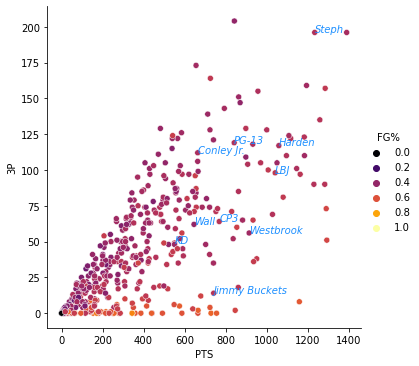

In [355]:
%matplotlib inline
sns.relplot(x = 'PTS', y = '3P', hue = 'FG%', data = ss, palette = 'inferno')
top_ten = ['Stephen Curry','Russell Westbrook','Chris Paul','John Wall','James Harden','LeBron James','Kevin Durant','Paul George','Mike Conley','Jimmy Butler']
t10_nick = ['Steph','Westbrook','CP3','Wall','Harden','LBJ','KD','PG-13','Conley Jr.','Jimmy Buckets']
for i,j in zip(top_ten, t10_nick):
    plt.text(ss.PTS[ss.player_name == i], ss['3P'][ss.player_name == i], j, color = 'dodgerblue', fontstyle = 'oblique')

In [1]:
anaconda upload NBA Salaries Project.ipynb

SyntaxError: invalid syntax (<ipython-input-1-afa166ee9688>, line 1)